# Fase 3 - Modeling & Evaluation Prediksi Kesejahteraan

## 1. Konfigurasi & Utility

In [16]:

from __future__ import annotations
import json
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import joblib

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

RANDOM_STATE = 42

# Resolve project root and data path
CWD = Path.cwd()
PROJECT_CANDIDATES = [CWD, CWD.parent]
DATA_PATH = None
PROJECT_ROOT = None
for base in PROJECT_CANDIDATES:
    candidate = base / 'dataset' / 'dataset_akhir' / 'dataset_final.csv'
    if candidate.exists():
        DATA_PATH = candidate
        PROJECT_ROOT = base
        break
if DATA_PATH is None:
    raise FileNotFoundError('dataset_final.csv tidak ditemukan pada path default.')

OUTPUT_DIR = PROJECT_ROOT / 'modelling'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = OUTPUT_DIR / 'best_model.joblib'
SCALER_PATH = OUTPUT_DIR / 'scaler.pkl'

print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {DATA_PATH}")
print(f"Output dir: {OUTPUT_DIR}")


Project root: /media/boba/DATA/STT Wastukancana/SEMESTER 5/MACHINE LEARNINGGGGG/TUGAS/UAS/kesejahteraan
Data path: /media/boba/DATA/STT Wastukancana/SEMESTER 5/MACHINE LEARNINGGGGG/TUGAS/UAS/kesejahteraan/dataset/dataset_akhir/dataset_final.csv
Output dir: /media/boba/DATA/STT Wastukancana/SEMESTER 5/MACHINE LEARNINGGGGG/TUGAS/UAS/kesejahteraan/modelling


## 2. Import Libraries & Load Data

In [17]:

# Load data
df_raw = pd.read_csv(DATA_PATH, index_col=False)
print(f"Raw shape: {df_raw.shape}")
print(f"Raw columns: {df_raw.columns.tolist()}")

# Drop unnamed / kosong
clean_df = df_raw.loc[:, ~df_raw.columns.str.contains('^Unnamed')].copy()

# Standardize column names
def clean_col(name: str) -> str:
    return (
        name.strip()
            .replace(' ', '_')
            .replace('-', '_')
            .replace('/', '_')
            .replace('\n', '_')
            .lower()
    )
clean_df.columns = [clean_col(c) for c in clean_df.columns]

print(f"Clean shape: {clean_df.shape}")
print(clean_df.dtypes)
print(clean_df.isnull().sum())
clean_df.head()


Raw shape: (405, 17)
Raw columns: ['id', 'kode_provinsi', 'nama_provinsi', 'nama_kabupaten_kota', 'jumlah_penduduk', 'jumlah_penduduk_miskin', 'jumlah_pengangguran_terbuka', 'pdrb_total_adhk', 'harapan_lama_sekolah', 'tahun', 'skor', 'kesejahteraan', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16']
Clean shape: (405, 12)
id                               int64
kode_provinsi                    int64
nama_provinsi                   object
nama_kabupaten_kota             object
jumlah_penduduk                  int64
jumlah_penduduk_miskin           int64
jumlah_pengangguran_terbuka      int64
pdrb_total_adhk                float64
harapan_lama_sekolah             int64
tahun                            int64
skor                           float64
kesejahteraan                   object
dtype: object
id                             0
kode_provinsi                  0
nama_provinsi                  0
nama_kabupaten_kota            0
jumlah_penduduk                0
juml

,id,kode_provinsi,nama_provinsi,nama_kabupaten_kota,jumlah_penduduk,jumlah_penduduk_miskin,jumlah_pengangguran_terbuka,pdrb_total_adhk,harapan_lama_sekolah,tahun,skor,kesejahteraan
0,1,32,JAWA BARAT,BOGOR,4813880,477200,686459,9.293200e+10,3,2010,149.587717,Sangat Sejahtera
1,2,32,JAWA BARAT,SUKABUMI,2358420,249600,255889,2.860100e+10,3,2010,46.247550,Tidak Sejahtera
2,3,32,JAWA BARAT,CIANJUR,2186790,311000,302214,1.969700e+10,3,2010,25.099967,Sangat Tidak Sejahtera
3,4,32,JAWA BARAT,BANDUNG,3205120,296300,556729,4.843200e+10,3,2010,70.089217,Cukup
4,5,32,JAWA BARAT,GARUT,2422330,335600,295040,2.546500e+10,3,2010,36.584667,Sangat Tidak Sejahtera


## 2. Exploratory Data Analysis (EDA)

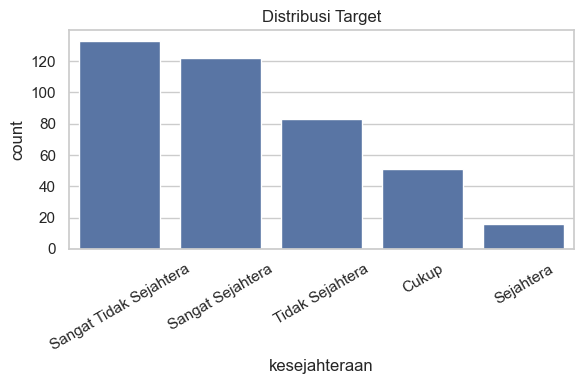

,id,kode_provinsi,jumlah_penduduk,jumlah_penduduk_miskin,jumlah_pengangguran_terbuka,pdrb_total_adhk,harapan_lama_sekolah,tahun,skor
count,405.000000,405.0,4.050000e+02,405.000000,405.000000,4.050000e+02,405.000000,405.000000,405.000000
mean,203.000000,32.0,1.752372e+06,153530.864198,158534.158025,4.928217e+10,3.659259,2017.000000,95.404212
std,117.057678,0.0,1.163248e+06,104329.140061,119288.444766,5.600873e+10,0.519372,4.325838,108.151918
min,1.000000,32.0,1.765060e+05,0.000000,8926.000000,2.026000e+09,1.000000,2010.000000,7.752850
25%,102.000000,32.0,9.767910e+05,79200.000000,66803.000000,1.715600e+10,3.000000,2013.000000,35.008183
50%,203.000000,32.0,1.654120e+06,141400.000000,141688.000000,2.781500e+10,4.000000,2017.000000,53.573617
75%,304.000000,32.0,2.444620e+06,214600.000000,206336.000000,5.253400e+10,4.000000,2021.000000,97.796900
max,405.000000,32.0,5.965400e+06,499100.000000,686459.000000,2.940000e+11,4.000000,2024.000000,580.512217


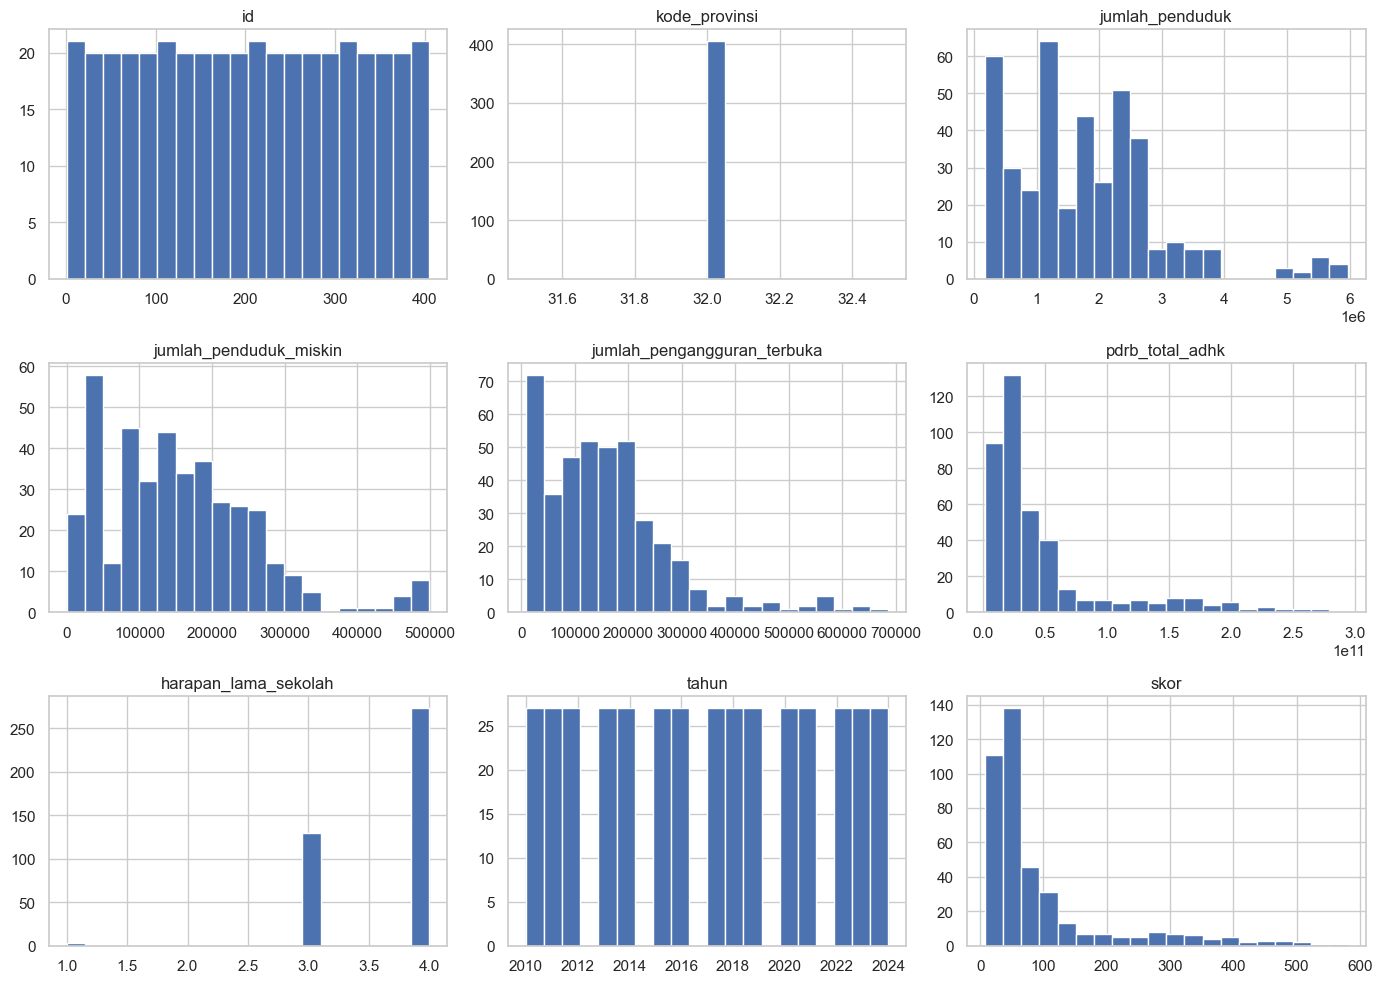

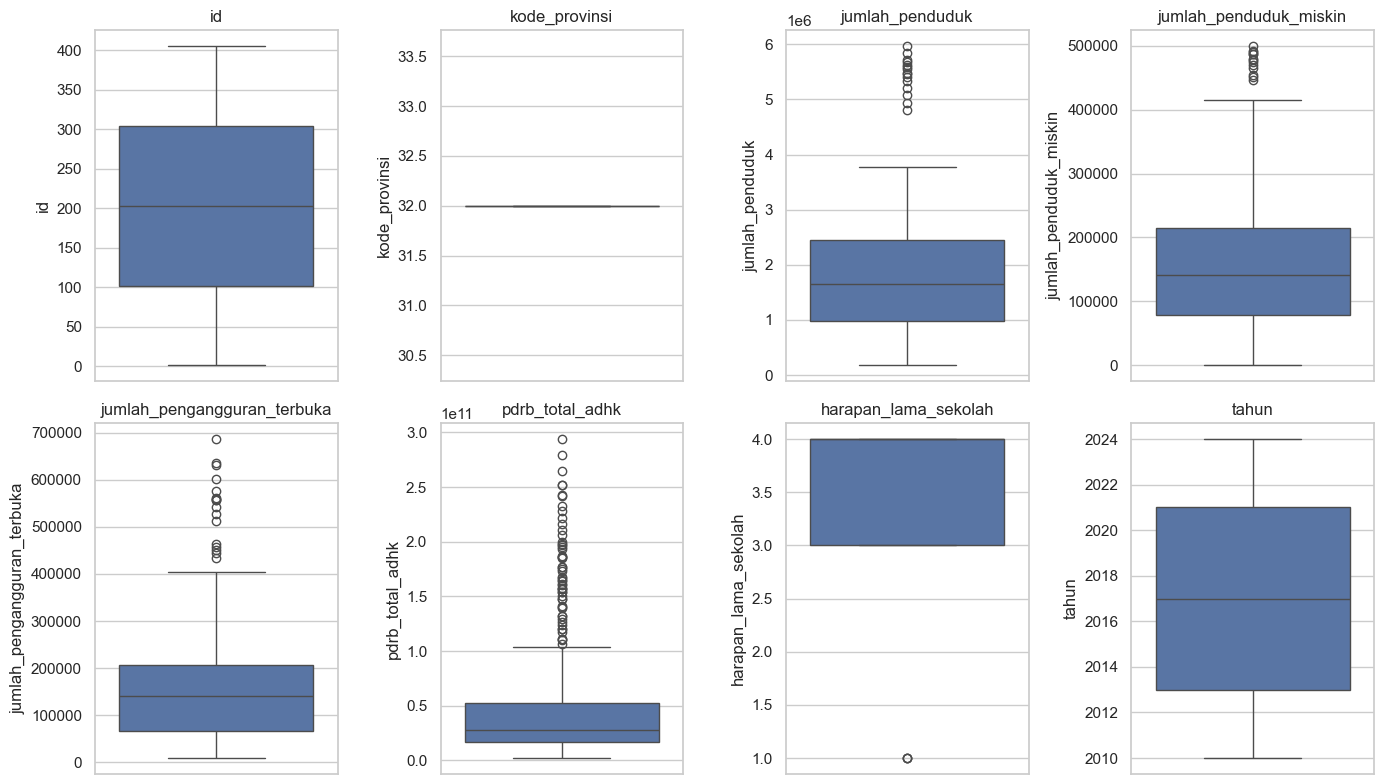

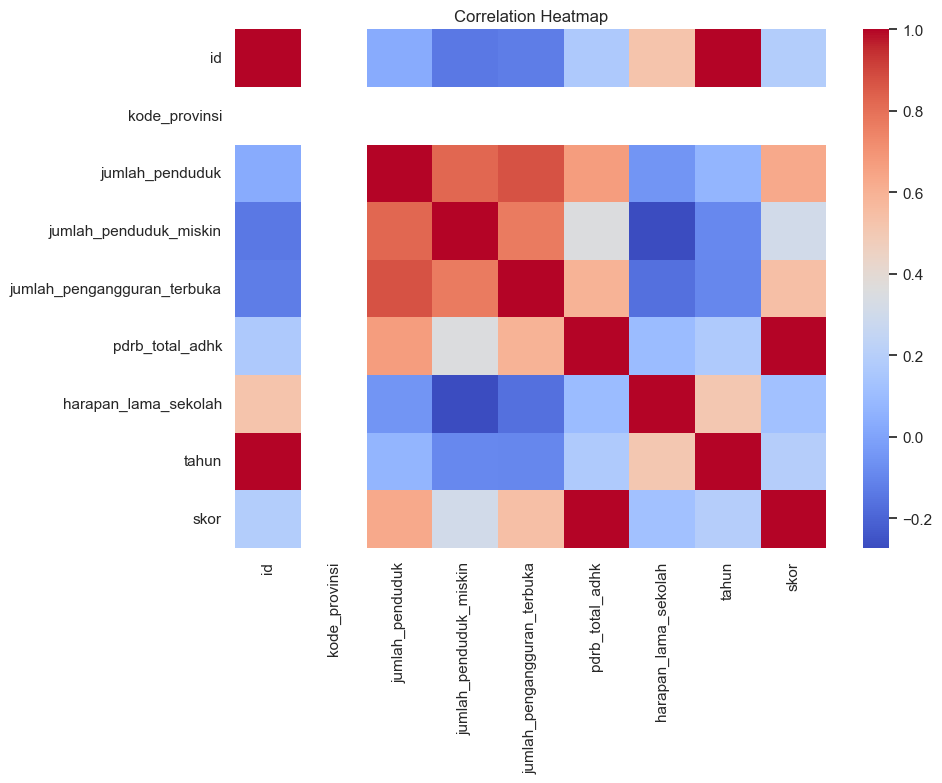

In [18]:

# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(data=clean_df, x='kesejahteraan', order=clean_df['kesejahteraan'].value_counts().index)
plt.title('Distribusi Target')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Numeric summary
num_cols = clean_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
display(clean_df[num_cols].describe())

# Histograms
clean_df[num_cols].hist(figsize=(14,10), bins=20)
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(14,8))
for i, col in enumerate(num_cols[:8]):
    plt.subplot(2,4,i+1)
    sns.boxplot(y=clean_df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
corr = clean_df[num_cols].corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


## 3. Feature Engineering

In [19]:

df = clean_df.copy()
# Drop constant or non-informative columns
cols_drop = ['id', 'kode_provinsi', 'nama_provinsi']
for c in cols_drop:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

# Derived features
if {'jumlah_penduduk_miskin','jumlah_penduduk'}.issubset(df.columns):
    df['penduduk_miskin_ratio'] = df['jumlah_penduduk_miskin'] / df['jumlah_penduduk']
if {'jumlah_pengangguran_terbuka','jumlah_penduduk'}.issubset(df.columns):
    df['pengangguran_ratio'] = df['jumlah_pengangguran_terbuka'] / df['jumlah_penduduk']
if {'pdrb_total_adhk','jumlah_penduduk'}.issubset(df.columns):
    df['pdrb_perkapita'] = df['pdrb_total_adhk'] / df['jumlah_penduduk']

# Check duplicates / missing
print(f"Duplicates: {df.duplicated().sum()}")
print(df.isnull().sum())

df.head()


Duplicates: 0
nama_kabupaten_kota            0
jumlah_penduduk                0
jumlah_penduduk_miskin         0
jumlah_pengangguran_terbuka    0
pdrb_total_adhk                0
harapan_lama_sekolah           0
tahun                          0
skor                           0
kesejahteraan                  0
penduduk_miskin_ratio          0
pengangguran_ratio             0
pdrb_perkapita                 0
dtype: int64


,nama_kabupaten_kota,jumlah_penduduk,jumlah_penduduk_miskin,jumlah_pengangguran_terbuka,pdrb_total_adhk,harapan_lama_sekolah,tahun,skor,kesejahteraan,penduduk_miskin_ratio,pengangguran_ratio,pdrb_perkapita
0,BOGOR,4813880,477200,686459,9.293200e+10,3,2010,149.587717,Sangat Sejahtera,0.099130,0.1426,19305.009680
1,SUKABUMI,2358420,249600,255889,2.860100e+10,3,2010,46.247550,Tidak Sejahtera,0.105834,0.1085,12127.186845
2,CIANJUR,2186790,311000,302214,1.969700e+10,3,2010,25.099967,Sangat Tidak Sejahtera,0.142218,0.1382,9007.266358
3,BANDUNG,3205120,296300,556729,4.843200e+10,3,2010,70.089217,Cukup,0.092446,0.1737,15110.822684
4,GARUT,2422330,335600,295040,2.546500e+10,3,2010,36.584667,Sangat Tidak Sejahtera,0.138544,0.1218,10512.605632


## 4. Data Splitting

In [20]:

from sklearn.utils import check_X_y

target_col = 'kesejahteraan'
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (324, 11), Test size: (81, 11)


## 5. Preprocessing Pipeline

In [21]:

from sklearn.preprocessing import StandardScaler

numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['int64','float64']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)


Numeric features: ['jumlah_penduduk', 'jumlah_penduduk_miskin', 'jumlah_pengangguran_terbuka', 'pdrb_total_adhk', 'harapan_lama_sekolah', 'tahun', 'skor', 'penduduk_miskin_ratio', 'pengangguran_ratio', 'pdrb_perkapita']
Categorical features: ['nama_kabupaten_kota']


## 6. Baseline Model Development & Cross-Validation

In [22]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

base_estimators = {
    'logreg': LogisticRegression(max_iter=1000, multi_class='auto', class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
    'rf': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
    'gb': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'svm': SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_STATE)
}

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1': 'f1_macro',
    'roc_auc_ovr': 'roc_auc_ovr_weighted'
}

cv_results = []

for name, est in base_estimators.items():
    pipe = Pipeline([
        ('preprocess', preprocess),
        ('clf', est)
    ])
    res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    cv_results.append({
        'model': name,
        'accuracy_mean': np.mean(res['test_accuracy']),
        'f1_mean': np.mean(res['test_f1']),
        'precision_mean': np.mean(res['test_precision']),
        'recall_mean': np.mean(res['test_recall']),
        'roc_auc_mean': np.mean(res['test_roc_auc_ovr'])
    })

cv_df = pd.DataFrame(cv_results).sort_values(by='f1_mean', ascending=False)
cv_df


,model,accuracy_mean,f1_mean,precision_mean,recall_mean,roc_auc_mean
2,gb,1.000000,1.000000,1.000000,1.000000,1.000000
1,rf,0.972260,0.931479,0.969454,0.913291,0.998897
3,svm,0.814904,0.729279,0.734715,0.773117,0.975233
0,logreg,0.802596,0.706310,0.717087,0.736156,0.968706


## 7. Hyperparameter Tuning 

In [23]:

# Pilih top-2 berdasarkan f1_cv
candidates = cv_df.head(2)['model'].tolist()
print('Top candidates:', candidates)

best_models = []

for name in candidates:
    if name == 'logreg':
        base = LogisticRegression(max_iter=2000, multi_class='auto', class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE)
        pipe = Pipeline([
            ('preprocess', preprocess),
            ('clf', base)
        ])
        param_grid = {
            'clf__C': [0.1, 0.5, 1.0, 2.0, 5.0],
            'clf__solver': ['lbfgs']
        }
        search = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_macro', cv=cv, n_jobs=-1)
    elif name == 'rf':
        base = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
        pipe = Pipeline([
            ('preprocess', preprocess),
            ('clf', base)
        ])
        param_dist = {
            'clf__n_estimators': [150, 200, 250, 300],
            'clf__max_depth': [None, 5, 10, 15],
            'clf__min_samples_split': [2, 4, 6, 8],
            'clf__min_samples_leaf': [1, 2, 3]
        }
        search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=15, scoring='f1_macro', cv=cv, n_jobs=-1, random_state=RANDOM_STATE)
    elif name == 'gb':
        base = GradientBoostingClassifier(random_state=RANDOM_STATE)
        pipe = Pipeline([
            ('preprocess', preprocess),
            ('clf', base)
        ])
        param_grid = {
            'clf__n_estimators': [100, 150, 200],
            'clf__learning_rate': [0.05, 0.1, 0.2],
            'clf__max_depth': [2, 3, 4]
        }
        search = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_macro', cv=cv, n_jobs=-1)
    else:
        continue
    search.fit(X_train, y_train)
    best_models.append({'name': name, 'search': search, 'best_estimator': search.best_estimator_, 'best_params': search.best_params_, 'best_score': search.best_score_})
    print(f"{name} best f1_macro (cv): {search.best_score_:.4f}")
    print('Best params:', search.best_params_)


Top candidates: ['gb', 'rf']
gb best f1_macro (cv): 1.0000
Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 2, 'clf__n_estimators': 100}
rf best f1_macro (cv): 0.9405
Best params: {'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 3, 'clf__max_depth': 15}


## 8. Evaluation on Test Set

Test metrics:


,model,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,gb,0.987654,0.988889,0.992593,0.990512,0.993445
1,rf,0.975309,0.978947,0.985185,0.981197,0.999440


Selected best model: gb


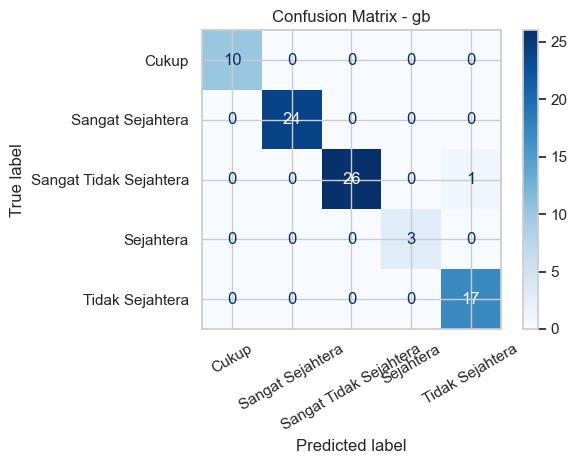

Classification report:
                        precision    recall  f1-score   support

                 Cukup       1.00      1.00      1.00        10
      Sangat Sejahtera       1.00      1.00      1.00        24
Sangat Tidak Sejahtera       1.00      0.96      0.98        27
             Sejahtera       1.00      1.00      1.00         3
       Tidak Sejahtera       0.94      1.00      0.97        17

              accuracy                           0.99        81
             macro avg       0.99      0.99      0.99        81
          weighted avg       0.99      0.99      0.99        81



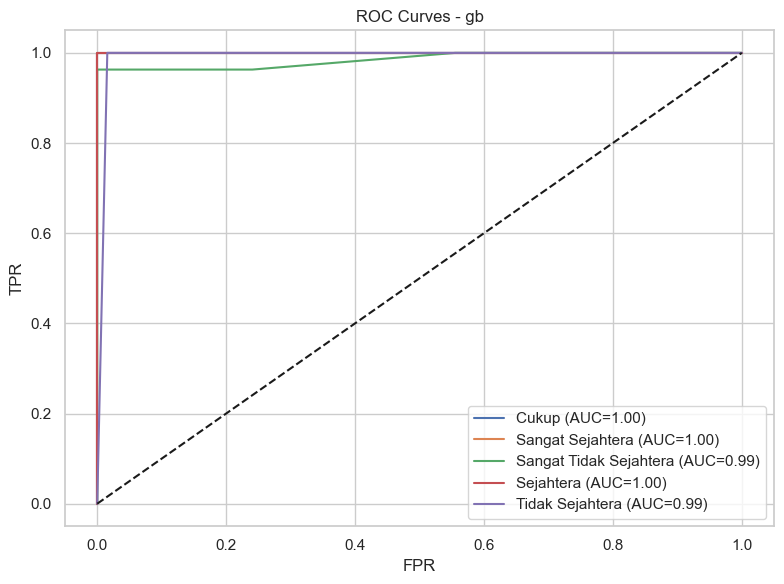

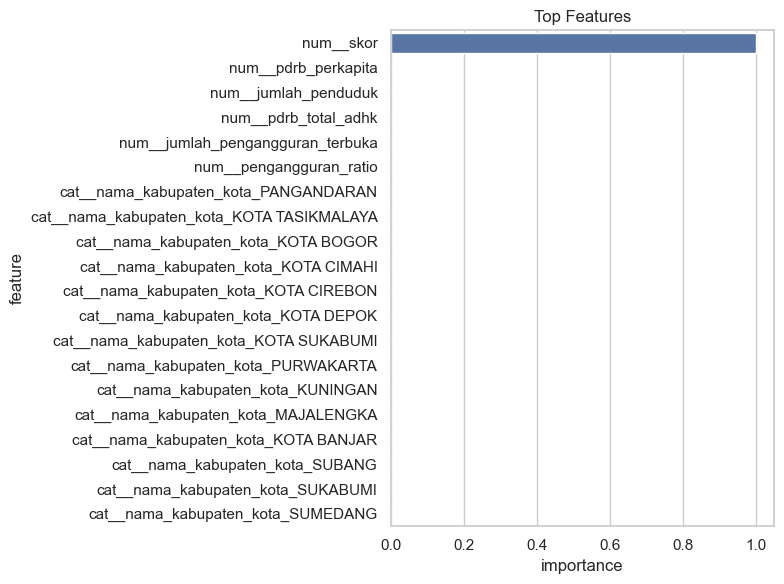

In [24]:

# Jika tuning kosong (edge case), fallback ke baseline terbaik
if not best_models:
    top_name = cv_df.iloc[0]['model']
    pipe = Pipeline([
        ('preprocess', preprocess),
        ('clf', base_estimators[top_name])
    ])
    pipe.fit(X_train, y_train)
    best_models.append({'name': top_name, 'search': None, 'best_estimator': pipe, 'best_params': {}, 'best_score': None})

eval_rows = []

for bm in best_models:
    model = bm['best_estimator']
    y_pred = model.predict(X_test)
    y_proba = None
    if hasattr(model.named_steps['clf'], 'predict_proba'):
        y_proba = model.predict_proba(X_test)
    elif hasattr(model.named_steps['clf'], 'decision_function'):
        dec = model.decision_function(X_test)
        if dec.ndim > 1:
            exp_dec = np.exp(dec - dec.max(axis=1, keepdims=True))
            y_proba = exp_dec / exp_dec.sum(axis=1, keepdims=True)
    metrics_row = {
        'model': bm['name'],
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred, average='macro'),
        'test_recall': recall_score(y_test, y_pred, average='macro'),
        'test_f1': f1_score(y_test, y_pred, average='macro')
    }
    if y_proba is not None:
        metrics_row['test_roc_auc'] = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    else:
        metrics_row['test_roc_auc'] = np.nan
    eval_rows.append(metrics_row)

eval_df = pd.DataFrame(eval_rows).sort_values(by='test_f1', ascending=False)
print('Test metrics:')
display(eval_df)

best_name = eval_df.iloc[0]['model']
best_entry = next(bm for bm in best_models if bm['name'] == best_name)
best_model = best_entry['best_estimator']
print(f"Selected best model: {best_name}")

# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best, labels=best_model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_).plot(cmap='Blues', xticks_rotation=30)
plt.title(f'Confusion Matrix - {best_name}')
plt.tight_layout()
plt.show()

print('Classification report:')
print(classification_report(y_test, y_pred_best))

# ROC curves per class (if probas available)
if hasattr(best_model.named_steps['clf'], 'predict_proba'):
    y_score = best_model.predict_proba(X_test)
    classes = best_model.classes_
    plt.figure(figsize=(8,6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve((y_test == cls).astype(int), y_score[:, i])
        auc_val = roc_auc_score((y_test == cls).astype(int), y_score[:, i])
        plt.plot(fpr, tpr, label=f"{cls} (AUC={auc_val:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC Curves - {best_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Feature importance / coefficients
def plot_feature_importance(model, feature_names):
    clf = model.named_steps['clf']
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
    elif hasattr(clf, 'coef_'):
        importances = np.mean(np.abs(clf.coef_), axis=0)
    else:
        print('Model has no feature importances.')
        return
    fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    fi_df = fi_df.sort_values(by='importance', ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(data=fi_df, x='importance', y='feature')
    plt.title('Top Features')
    plt.tight_layout()
    plt.show()

feature_names = best_model.named_steps['preprocess'].get_feature_names_out()
plot_feature_importance(best_model, feature_names)


## 9. Model Comparison & Selection

In [25]:

comparison_df = cv_df.merge(eval_df, on='model', how='left')
display(comparison_df.sort_values(by='test_f1', ascending=False))


,model,accuracy_mean,f1_mean,precision_mean,recall_mean,roc_auc_mean,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,gb,1.000000,1.000000,1.000000,1.000000,1.000000,0.987654,0.988889,0.992593,0.990512,0.993445
1,rf,0.972260,0.931479,0.969454,0.913291,0.998897,0.975309,0.978947,0.985185,0.981197,0.999440
2,svm,0.814904,0.729279,0.734715,0.773117,0.975233,NaN,NaN,NaN,NaN,NaN
3,logreg,0.802596,0.706310,0.717087,0.736156,0.968706,NaN,NaN,NaN,NaN,NaN


## 10. Model Saving

In [26]:

joblib.dump(best_model, MODEL_PATH)
print(f"Saved best model to {MODEL_PATH}")

# Extract fitted scaler
pre = best_model.named_steps['preprocess']
scaler = None
if 'num' in pre.named_transformers_:
    num_pipe = pre.named_transformers_['num']
    if hasattr(num_pipe, 'named_steps'):
        scaler = num_pipe.named_steps.get('scaler')
if scaler is not None:
    joblib.dump(scaler, SCALER_PATH)
    print(f"Saved scaler to {SCALER_PATH}")
else:
    print('Scaler not found (check pipeline).')

# Save class labels for reference
classes_path = OUTPUT_DIR / 'target_classes.json'
classes = best_model.classes_.tolist()
classes_path.write_text(json.dumps({'classes': classes}, indent=2))
print(f"Saved target classes to {classes_path}")


Saved best model to /media/boba/DATA/STT Wastukancana/SEMESTER 5/MACHINE LEARNINGGGGG/TUGAS/UAS/kesejahteraan/modelling/best_model.joblib
Saved scaler to /media/boba/DATA/STT Wastukancana/SEMESTER 5/MACHINE LEARNINGGGGG/TUGAS/UAS/kesejahteraan/modelling/scaler.pkl
Saved target classes to /media/boba/DATA/STT Wastukancana/SEMESTER 5/MACHINE LEARNINGGGGG/TUGAS/UAS/kesejahteraan/modelling/target_classes.json
